In [ ]:
%load_ext autoreload
%autoreload 2

In [99]:
import torch
import numpy as np
import matplotlib.pyplot as plt

ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
torch.set_default_tensor_type(ttype)

from nonlinear_env import Nonlinear
from util import simulate, train_model, eval_model
from controllers import LinearController

In [100]:
def plot_stability(controller, env, N):
    controller.reset()
    obs = [env.reset()]

    for _ in range(N):
        u = controller(obs[-1])
        obs += [env.step(u)[0]]
    obs = torch.stack(obs).mean(dim=1).detach().cpu().numpy()
    print(obs[-1])
    plt.plot(np.arange(len(obs)), obs)

tensor(nan, grad_fn=<MeanBackward0>)
[nan nan]


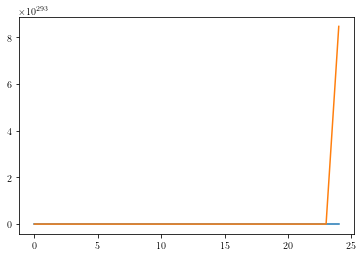

In [134]:
batch_size = 512
n_layers = 0
dim_hidden = 2
learning_rate = 1e-2

# System Dynamics
A = lambda x: torch.eye(2).view(1, 2, 2).repeat(batch_size, 1, 1)
B = lambda x: torch.tensor([0., 1.]).view(1, 2, 1).repeat(batch_size, 1, 1)
Z = lambda x: torch.stack([x[:, 1], x[:, 0] ** 2]).t()
C1 = lambda x: torch.stack([x[:, 1], -x[:, 0], torch.zeros_like(x[:, 1]), -x[:, 1]]).view(2, 2, batch_size).permute(2, 0, 1)
C2 = lambda x: torch.stack([-torch.ones_like(x[:, 0]), x[:, 0]]).view(1, 2, batch_size).permute(2, 0, 1)
W = torch.eye(2) * 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

controller = LinearController(2, 1, dim_h=dim_hidden, hidden=n_layers).to(device)
env = Nonlinear(A, B, Z, C1, C2, W=W, batch_size=batch_size)
controller.init_weights()

# controller.load_state_dict(starting)
n_steps = 100

loss = simulate(controller, env, n_steps)
print(loss.mean())

plot_stability(controller, env, 100)
eval_envs = [Nonlinear(A, B, Z, C1, C2, W=k, batch_size=batch_size) for k in [None, torch.eye(2) * 0.0005, torch.eye(2) * 0.001]]

In [ ]:
import copy
import time

n_epochs = 300
n_steps = 100

controllers = []

errs = np.linspace(0, 0.1, 11)

for i in errs:
    while True:
        controller.init_weights()
        loss = simulate(controller, env, n_steps).mean()
        if not np.isnan(loss.detach().cpu().numpy().item()):
            print("Starting", i)

            start = time.time()
            losses = train_model(controller, env, n_epochs, n_steps, 1e-2, noise=i)
            end = time.time()
            print("train", i, end - start)

            loss = simulate(controller, env, n_steps).mean()
            if not np.isnan(loss.detach().cpu().numpy().item()):
                controllers.append(copy.deepcopy(controller.state_dict()))
                break

In [136]:
n_epochs = 300
n_steps = 100

errs = np.linspace(0, 0.1, 3)

vals_05 = []
env = eval_envs[1]

for state in controllers:
    controller.load_state_dict(state)
    i_vals = []
    for j in errs:
        start = time.time()
        eval_loss = eval_model(controller, env, n_epochs, n_steps, noise=j)
        end = time.time()
        mean_loss = np.mean(eval_loss)
        i_vals.append(mean_loss)
    vals_05.append(i_vals)

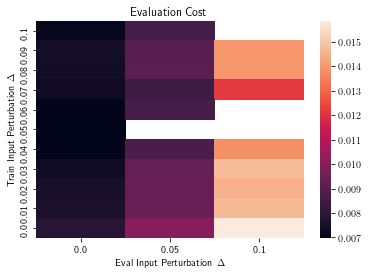

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

sns.heatmap(vals_05[::-1])
plt.gca().set_xticklabels(np.linspace(0, 0.1, 3))
plt.gca().set_yticklabels(errs[::-1])
plt.xlabel('Eval Input Perturbation $\Delta$')
plt.ylabel('Train Input Perturbation $\Delta$')
plt.title('Evaluation Cost')
plt.savefig('eval_cost_heatmap_05')
plt.show()
plt.close()

In [ ]:
import time

n_epochs = 300
n_steps = 100

errs = np.linspace(0, 0.1, 11)

vals = []

for state in controllers:
    controller.load_state_dict(state)
    i_vals = []
    for j in errs:
        start = time.time()
        eval_loss = eval_model(controller, env, n_epochs, n_steps, noise=j)
        end = time.time()
        mean_loss = np.mean(eval_loss)
        i_vals.append(mean_loss)
    vals.append(i_vals)

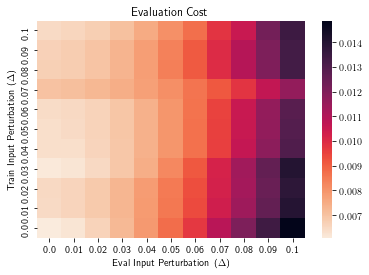

<function matplotlib.pyplot.close(fig=None)>

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

errs = np.linspace(0, 0.1, 11)
sns.heatmap(vals[::-1], cmap=sns.cm.rocket_r)
plt.gca().set_xticklabels(errs)
plt.gca().set_yticklabels(errs[::-1])
plt.xlabel('Eval Input Perturbation ($\Delta$)')
plt.ylabel('Train Input Perturbation ($\Delta$)')
plt.title('Evaluation Cost')
plt.savefig('eval_cost_heatmap')
plt.show()
plt.close

In [53]:
import time

n_epochs = 300
n_steps = 100

errs = [0.11, 0.12, 0.13]

vals2 = []

for state in controllers:
    controller.load_state_dict(state)
    i_vals = []
    for j in errs:
        start = time.time()
        eval_loss = eval_model(controller, env, n_epochs, n_steps, noise=j)
        end = time.time()
        mean_loss = np.mean(eval_loss)
        i_vals.append(mean_loss)
    vals2.append(i_vals)

In [ ]:
controller.load_state_dict(starting)
controller.reset()
controller.state_dict()

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel('epochs')
plt.ylabel('mean_loss')
plt.show()

In [ ]:
np.mean(eval_model(controller, env, n_epochs, n_steps))

In [ ]:
losses = eval_model(controller, env, n_epochs, n_steps)

In [ ]:
np.mean(losses)

In [ ]:
n_epochs = 200
n_steps = 100

losses = train_model(controller, env, opt, n_epochs, n_steps, v=False)
plt.plot(np.arange(len(losses)), losses)
plt.xlabel('epochs')
plt.ylabel('mean_loss')
plt.show()

In [ ]:
sim_loss = simulate(controller, env, 100)[:, 0].detach().cpu().numpy()
plt.plot(np.arange(len(sim_loss)), sim_loss)
plt.xlabel('t')
plt.ylabel('loss')
plt.show()

plot_stability(controller, env, 100)
plt.xlabel('t')
plt.ylabel('x')
plt.show()
print(list(controller.parameters()))